# Independence weights for policy learning
## Shucheng Liu 5.27
## Independence Weights
First we compute the distance covariate optimal weights (DCOWs) and optimize it to get the the weights. Note that the work is done by optimizing an non-convex OSQP problem.
$$\mathbf{w}_n^d\in\underset{\mathbf{w}=(w_1,...,w_n)}{\operatorname*{argmin}}\mathcal{D}(\mathbf{w})\text{ such that }\sum_{i=1}^nw_i=n,\text{ and }w_i\geq0\text{ for }i=1,\ldots,n.$$


In [1]:
from independence_weights import *
from simulate_data import *

In [2]:
def independence_weights(A, X, lambda_=0, decorrelate_moments=False, preserve_means=False, dimension_adj=True):
    n = A.shape[0]
    p = X.shape[1]
    gamma = 1
    # dif
    A = np.asarray(A).reshape(-1, 1)
    Adist = squareform(pdist(A, 'euclidean'))
    Xdist = squareform(pdist(X, 'euclidean'))

    # terms for energy-dist(Wtd A, A)
    Q_energy_A = -Adist / n ** 2
    aa_energy_A = np.sum(Adist, axis=1) / n ** 2

    # terms for energy-dist(Wtd X, X)
    Q_energy_X = -Xdist / n ** 2
    aa_energy_X = np.sum(Xdist, axis=1) / n ** 2

    mean_Adist = np.mean(Adist)
    mean_Xdist = np.mean(Xdist)

    Xmeans = np.mean(Xdist, axis=1)
    Xgrand_mean = np.mean(Xmeans)
    XA = Xdist + Xgrand_mean - np.add.outer(Xmeans, Xmeans)

    Ameans = np.mean(Adist, axis=1)
    Agrand_mean = np.mean(Ameans)
    AA = Adist + Agrand_mean - np.add.outer(Ameans, Ameans)

    # quadratic term for weighted total distance covariance
    P = XA * AA / n ** 2

    if preserve_means:
        if decorrelate_moments:
            Constr_mat = (A - np.mean(A)) * (X - np.mean(X, axis=0))
            Amat = sparse.vstack([np.eye(n), np.ones((1, n)), X.T,
                                  A.reshape(1, -1), Constr_mat.T])
            lvec = np.concatenate([np.zeros(n), [n], np.mean(
                X, axis=0), [np.mean(A)], np.zeros(X.shape[1])])
            uvec = np.concatenate(
                [np.inf * np.ones(n), [n], np.mean(X, axis=0), [np.mean(A)], np.zeros(X.shape[1])])
        else:
            Amat = sparse.vstack(
                [np.eye(n), np.ones((1, n)), X.T, A.reshape(1, -1)])
            lvec = np.concatenate(
                [np.zeros(n), [n], np.mean(X, axis=0), [np.mean(A)]])
            uvec = np.concatenate(
                [np.inf * np.ones(n), [n], np.mean(X, axis=0), [np.mean(A)]])
    else:
        if decorrelate_moments:
            Constr_mat = (A - np.mean(A)) * (X - np.mean(X, axis=0))
            Amat = sparse.vstack([np.eye(n), np.ones((1, n)), Constr_mat.T])
            lvec = np.concatenate([np.zeros(n), [n], np.zeros(X.shape[1])])
            uvec = np.concatenate(
                [np.inf * np.ones(n), [n], np.zeros(X.shape[1])])
        else:
            Amat = sparse.vstack([np.eye(n), np.ones((1, n))])
            lvec = np.concatenate([np.zeros(n), [n]])
            uvec = np.concatenate([np.inf * np.ones(n), [n]])

    if dimension_adj:
        Q_energy_A_adj = 1 / np.sqrt(p)
        Q_energy_X_adj = 1
        sum_adj = Q_energy_A_adj + Q_energy_X_adj
        Q_energy_A_adj /= sum_adj
        Q_energy_X_adj /= sum_adj
    else:
        Q_energy_A_adj = Q_energy_X_adj = 1 / 2

    for na in range(1, 50):
        p = sparse.csr_matrix(2 * (P + gamma * (Q_energy_A * Q_energy_A_adj + Q_energy_X *
                                                Q_energy_X_adj) + lambda_ * np.diag(np.ones(n)) / n ** 2))
        A = Amat

        l = lvec
        u = uvec
        q = 2 * gamma * (aa_energy_A * Q_energy_A_adj +
                         aa_energy_X * Q_energy_X_adj)
        m = osqp.OSQP()
        m.setup(P=p, q=q, A=A, l=l, u=u, max_iter=int(2e5),
                eps_abs=1e-8, eps_rel=1e-8, verbose=False)
        results = m.solve()
        if not np.any(results.x > 1e5):
            break

    weights = results.x

    weights[weights < 0] = 0

    QM_unpen = P + gamma * (Q_energy_A * Q_energy_A_adj +
                            Q_energy_X * Q_energy_X_adj)

    quadpart_unpen = weights.T @ QM_unpen @ weights
    quadpart_unweighted = np.sum(QM_unpen)

    quadpart = quadpart_unpen + np.sum(weights ** 2) * lambda_ / n ** 2

    qvec = 2 * gamma * (aa_energy_A * Q_energy_A_adj +
                        aa_energy_X * Q_energy_X_adj)
    linpart = weights @ qvec
    linpart_unweighted = np.sum(qvec)

    objective_history = quadpart + linpart + gamma * \
        (-mean_Xdist * Q_energy_X_adj - mean_Adist * Q_energy_A_adj)

    D_w = quadpart_unpen + linpart + gamma * \
        (-mean_Xdist * Q_energy_X_adj - mean_Adist * Q_energy_A_adj)
    D_unweighted = quadpart_unweighted + linpart_unweighted + gamma * \
        (-mean_Xdist * Q_energy_X_adj - mean_Adist * Q_energy_A_adj)

    qvec_full = 2 * (aa_energy_A * Q_energy_A_adj +
                     aa_energy_X * Q_energy_X_adj)

    quadpart_energy_A = weights.T @ Q_energy_A @ weights * Q_energy_A_adj
    quadpart_energy_X = weights.T @ Q_energy_X @ weights * Q_energy_X_adj
    quadpart_energy = quadpart_energy_A * \
        Q_energy_A_adj + quadpart_energy_X * Q_energy_X_adj

    distcov_history = weights.T @ P @ weights
    unweighted_dist_cov = np.sum(P)

    linpart_energy = weights @ qvec_full
    linpart_energy_A = 2 * weights @ aa_energy_A * Q_energy_A_adj
    linpart_energy_X = 2 * weights @ aa_energy_X * Q_energy_X_adj

    energy_history = quadpart_energy + linpart_energy - \
        mean_Xdist * Q_energy_X_adj - mean_Adist * Q_energy_A_adj
    energy_A = quadpart_energy_A + linpart_energy_A - mean_Adist * Q_energy_A_adj
    energy_X = quadpart_energy_X + linpart_energy_X - mean_Xdist * Q_energy_X_adj

    ess = (np.sum(weights)) ** 2 / np.sum(weights ** 2)

    ret_obj = {
        'weights': weights,
        'A': A,
        'opt': results,
        'objective': objective_history,
        'D_unweighted': D_unweighted,
        'D_w': D_w,
        'distcov_unweighted': unweighted_dist_cov,
        'distcov_weighted': distcov_history,
        'energy_A': energy_A,
        'energy_X': energy_X,
        'ess': ess
    }

    return ret_obj






# Simulation Setup 

And we use the data-generating setup of Vegetabile et al. (2021) in the independence weight paper, the following are the details of setup. The definition of C in R package has a little different from the definition of C in the supplementary material section I of the paper, and I used the definition in R package.

**Parameter Setup**  
Let $n = 1000$ be the sample size, with the following means:  
$\mu_{X1} = -0.5$, $\mu_{X2} = 1$, $\mu_{X3} = 0.3$

**Covariate Generation**  
Generate covariates $X_i$:  
$X1 \sim \mathcal{N}(\mu_{X1}, 1)$, $X2 \sim \mathcal{N}(\mu_{X2}, 1)$, $X3 \sim \mathcal{N}(0, 1)$, $X4 \sim \mathcal{N}(\mu_{X2}, 1)$, $X5 \sim \text{Bernoulli}(\mu_{X3})$

**Intermediate Variable Generation**  
Generate intermediate variables $Z_i$:  
$Z1 = \exp\left(\frac{X1}{2}\right)$, $Z2 = \frac{X2}{1 + \exp(X1)} + 10$, $Z3 = \frac{X1 \cdot X3}{25} + 0.6$, $Z4 = (X4 - \mu_{X2})^2$, $Z5 = X5$

**Treatment Variable Generation**  
Generate treatment variable $A$:  
$\mu_A = 5 |X1| + 6 |X2| + 3 |X5| + |X4|$  
$A \sim \chi^2(3)+\mu_A$

**Outcome Variable Generation**  
For the case with treatment effect ($A_{\text{effect}} = \text{TRUE}$):  
$$C=E((X_1+3)+2(X_2-25)^2+X_3)$$
$$Y = \frac{-0.15 A^2 + A(X1^2 + X2^2) - 15 + (X1 + 3)^2 + 2(X2 - 25)^2 + X3 - C + \epsilon}{50}, \quad \epsilon \sim \mathcal{N}(0, 1)$$  
True ADRF (by integration)
$$E(Y(a))=-0.03a^2+0.065a-0.3.$$


**Dataset**  
The final generated dataset $\mathcal{D}$ includes:  
$\mathcal{D} = \{ Y, A, Z1, Z2, Z3, Z4, Z5, \text{truth} \}$  
and the original covariate dataset $\mathcal{X}$:  
$\mathcal{X} = \{ X1, X2, X3, X4, X5 \}$



In [3]:
import numpy as np
import torch
import pandas as pd
from scipy.stats import chi2


def simulate_data(seed=1, nobs=1000, MX1=-0.5, MX2=1, MX3=0.3, A_effect=True):
    np.random.seed(seed)

    # Generate covariates and dose
    X1 = np.random.normal(loc=MX1, scale=1, size=nobs)
    X2 = np.random.normal(loc=MX2, scale=1, size=nobs)
    X3 = np.random.normal(loc=0, scale=1, size=nobs)
    X4 = np.random.normal(loc=MX2, scale=1, size=nobs)
    X5 = np.random.binomial(n=1, p=MX3, size=nobs)

    Z1 = np.exp(X1 / 2)
    Z2 = (X2 / (1 + np.exp(X1))) + 10
    Z3 = (X1 * X3 / 25) + 0.6
    Z4 = (X4 - MX2) ** 2
    Z5 = X5

    muA = 5 * np.abs(X1) + 6 * np.abs(X2) + 3 * np.abs(X5) + np.abs(X4)

    A = (chi2.rvs(df=3, loc=0, scale=1, size=nobs) + muA)/45

    def true_density_A_X(A, X):
        muA_true = 5 * np.abs(X[:, 0]) + 6 * np.abs(X[:, 1]) + \
            3 * np.abs(X[:, 4]) + np.abs(X[:, 3])
        return chi2.pdf(A, df=3, loc=0, scale=1, nc=muA_true)

    if A_effect:
        Cnum = 1161.25
        Y = -0.15 * A ** 2 + A * (X1 ** 2 + X2 ** 2) - 15 + (X1 + 3) ** 2 + 2 * (
            X2 - 25) ** 2 + X3 - Cnum + np.random.normal(scale=1, size=nobs)
        Y = Y / 50
        
        truth = -0.15 * A ** 2 + A * 3.25 - 15
        truth = truth / 50
    else:
        
        Y = X1 + X1 ** 2 + X2 + X2 ** 2 + X1 * X2 + \
            X5 + np.random.normal(scale=1, size=nobs)
        truth = 5.05
    

    datz = pd.DataFrame({
        'Y': Y,
        'A': A,
        'Z1': Z1,
        'Z2': Z2,
        'Z3': Z3,
        'Z4': Z4,
        'Z5': Z5,
        'truth': truth
    })

    datx = pd.DataFrame({
        'X1': X1,
        'X2': X2,
        'X3': X3,
        'X4': X4,
        'X5': X5
    })

    return {
        'data': datz,
        'true_adrf': truth,
        'original_covariates': datx,
        'true_density_A_X': true_density_A_X
    }

We can test the weights in the simulated data

In [4]:

simdat = simulate_data(seed=999, nobs=500)

y = simdat['data']['Y']
A = simdat['data']['A']
X = simdat['data'][['Z1', 'Z2', 'Z3', 'Z4', 'Z5']].values


dcows = independence_weights(A, X)

print(f"dcows['distcov_unweighted'] = {dcows['distcov_unweighted']}")
print(f"dcows['distcov_weighted'] = {dcows['distcov_weighted']}")

dcows['distcov_unweighted'] = 0.013619855901760396
dcows['distcov_weighted'] = 0.002978216646366547


/Users/liushucheng/miniconda3/envs/try-mps/lib/python3.8/site-packages/osqp/utils.py:122: UserWarning: Converting sparse A to a CSC (compressed sparse column) matrix. (It may take a while...)
  warn("Converting sparse A to a CSC " +


# Policy evaulation
We used the weights to estimate the ADRF, which also called value function in the policy learning literature. We first set a space of linear policies, which is the most common setting: $\mathscr{T}=\{\tau(x)=\beta^{\intercal}x:\left\|\beta\right\|_{2}\leq W_{2}\}$ and constrained the treatment in [1.5,45] to prevent finding the boundries that have no data exist.

We have many methods to estimate the value function using weights:
1. The first method is the simpliest that used in the Kallus and Zhou (2018). It is easy to derivate and do grediant decent optimization. 
$$\hat{v}_\tau=\frac1{nh}\sum_{i=1}^nK\left(\frac{\tau(x_i)-t_i}h\right){y_i}{\omega_i}$$

2. The second method is double robust estimator, which can be defined if we can get the estimator $\hat{r}(\tau(X_i),x_i)$ 

$$\hat{v}_\tau^{\mathrm{DR}}=\begin{aligned}\frac{1}{n}\sum_{i=1}^n\left[\hat{r}(\tau(X_i),x_i)+\frac{\omega_i}{h}K\left(\frac{\tau(x_i)\boldsymbol{-}t_i}{h}\right)(y_i-\hat{r}(t_i,x_i))\right]\end{aligned}$$

3. The third method is self-nomarlized estimator and it can reduce variance but it is a bit hard to derivate and use gradiant decent method when the kernel function is a bit complicated such as Epanechnikov kernel 
$$\hat{v}_\tau^\mathrm{norm}=\frac{\sum_{i=1}^ny_i\omega_iK\left(\frac{\tau(x_i)-t_i}h\right)}{\sum\omega_iK\left(\frac{\tau(x_i)-t_i}h\right)}$$

4. The last is self-nomarlized estimator using double robust method
$$\hat{v}_\tau^{\mathrm{DR,norm}} = \frac{1}{n} \sum_{i=1}^n \hat{r}(\tau(X_i), x_i) + \frac{\sum_{i=1}^n (Y_i - \hat{r}(t_i, x_i)) w_i K_h(\tau(X_i) - t_i)}{\sum_{i=1}^n K_h(\tau(X_i) - t_i)}
$$

We use the first method to do the policy evaulation work, we conpare different methods such as GPS, DCOWs (and discrete methods) with the true ADRF to find which methods performs better

# Generallized propensity score
I found that the paper in Kallus and Zhou (2018) does not use the right way to estimate GPS (maybe I skipped this part from their code) and their methods performs worse than the standard GPS. So I find a way in estimating GPS under normal assumption in the paper "Hirano K, Imbens G W. The propensity score with continuous treatments" the details are as follows.

First I use Kernel methods to get the density function $\hat{f(t)}$ and then I suppose the distribution of $Ti|Xi$ is normal that:
$$T_i|X_i\sim\mathrm{N}(\beta_0+\beta_1'X_i,\sigma^2).$$
I use linear regression to get the parameter and the variance of the linear model and I get the estimation of the density function that:
$$\hat{f(T_i|X_i)}=\frac{1}{\sqrt{2\pi\hat{\sigma}^2}}\exp\left(-\frac{1}{2\hat{\sigma}^2}(T_i-\hat{\beta}_0-\hat{\beta}_1'X_i)^2\right).$$
So we can get the weights $w_i$ that defines as $w_i=\frac{\hat{f(t_i)}}{\hat{f(t_i|x_i)}}$ 





In [5]:
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
def off_policy_evaulation_DCOWs(**params): 
#using DCOWs to estimate the value function
    
    y_out = params['y']; x = params['x']; h = params['h']; n = params['n']; t_lo = params['t_lo'];  t_hi = params['t_hi']
    kernel = params['kernel_func'];kernel_int =  params['kernel_int_func']
    if ('y_samp' in params.keys()):
        y_out = params['y_samp']
    if ('T_samp' in params.keys()): 
        T = params['T_samp']
    else: 
        T = params['T']
    if ('x_samp' in params.keys()):
        x = params['x_samp']

    weights=independence_weights(T, x)['weights']
    
    
    value_function_estimation = 0
    tau = params['tau']
    clip_tau = np.clip(tau, t_lo, t_hi)
    
    for i in np.arange(n): 
        
        if (abs(clip_tau[i] - t_lo) <= h):
            alpha = kernel_int((t_lo-clip_tau[i])/h, 1)
        elif (abs(clip_tau[i] - t_hi) <= h):
            alpha = kernel_int(-1,  (t_hi - clip_tau[i])/h )
        else:
            alpha = 1
       
        value_function_estimation += kernel( (clip_tau[i] - T[i])/h )*weights[i] * y_out[i]/ (n*h)
    
    return value_function_estimation



def off_policy_evaulation_GPS(**params): 
    THRESH = params['threshold']
    y_out = params['y']
    x = params['x']
    h = params['h']
    Q = params['Q']
    n = params['n']
    t_lo = params['t_lo']
    t_hi = params['t_hi']
    kernel = params['kernel_func']
    kernel_int = params['kernel_int_func']
    
    if 'y_samp' in params:
        y_out = params['y_samp']
    if 'T_samp' in params: 
        T = params['T_samp']
    else: 
        T = params['T']
    if 'x_samp' in params:
        x = params['x_samp']

    BMI_IND = params.get('BMI_IND')  # propensity score for warfarin data evaluations 
    if params.get('DATA_TYPE') == 'warfarin': 
        x = params['x'][:, BMI_IND]
    model = LinearRegression()
    model.fit(x, T)
    mu = model.predict(x)
    kde = gaussian_kde(T)
    f_t = kde(T)

    residuals = T - mu
    
    mu = 0
    Q_num =0
    tau = params['tau']
    clip_tau = np.clip(tau, t_lo, t_hi)
    
    
    
    for i in range(n): 
        Q_i = Q(x[i], T[i], model.intercept_,model.coef_ ,np.mean(residuals**2))
        Q_i = np.maximum(Q_i, 0.01)
        f_t[i]=np.minimum(f_t[i], 100)
        if abs(clip_tau[i] - t_lo) <= h:
            alpha = kernel_int((t_lo - clip_tau[i]) / h, 1)
        elif abs(clip_tau[i] - t_hi) <= h:
            alpha = kernel_int(-1, (t_hi - clip_tau[i]) / h)
        else:
            alpha = 1
        
        w_i = np.minimum(f_t[i]/Q_i, 1/THRESH)  # thresholding the Q function
        # Print the first six of all parameters
    
        mu += kernel((clip_tau[i] - T[i]) / h) * 1.0 * y_out[i] *w_i/ (  1.0 * n * h )
        if kernel((clip_tau[i] - T[i]) / h) * 1.0 * y_out[i] *f_t[i]/ (Q_i* 1.0 * n * h )>1:
            print(f"w_i: {f_t[i]/Q_i}, y_out[i]: {y_out[i]}, n: {n}, h: {h}, alpha: {alpha}, kernel((clip_tau[i] - T[i]) / h):{kernel((clip_tau[i] - T[i]) / h)}", f"Q_i: {Q_i}, f_t[i]: {f_t[i]}", f"delta_mu: {kernel((clip_tau[i] - T[i]) / h) * 1.0 * y_out[i] *f_t[i]/ (Q_i* 1.0 * n * h )}")
        Q_num+=w_i
    #print(f"Q_num: {Q_num}")    
    return mu


# First simulation study for policy evaulation
To show the effectiveness of the DCOWS method in policy evaulation we just use the settings in Kallus and Zhou (2018) that we have

$X_i\sim Unif[0,1]$ where i=1,2,3,4,5

$y=2|X_1+X_2+X_3+X_4+X_5-t|^{1.5}+0.2\epsilon$, where $\epsilon\sim N(0,1)$

$T\mid X\sim N(x+0.1,0.5).$ 

$\tau(x_i)=\beta x_i$ and we can see that the $E(Y(\tau(X)))=0$ when $\beta=1.$ so it is easy to see the result




In [6]:
from sklearn.linear_model import LinearRegression
from scipy.stats import truncnorm
from scipy.stats import norm
from scipy.stats import gamma
def trunc_norm_Q(x, t, t_lo, t_hi):
    # Get pdf from  truncated normally distributed propensity score (standard normal centered around (x-t)
    # I was wondering if this is the GPS method
    sc = 0.5
    mu = np.mean(x)
    a, b = (t_lo - mu) / sc, (t_hi - mu) / sc
    return truncnorm.pdf(t, a,b, loc = mu, scale = sc)

def GPS_Q(x, t, mu, coef, sigma):
    
    mean = mu + np.dot(x, coef)
    
    pdf_value = norm.pdf(t, loc=mean, scale=sigma)
    return pdf_value

def GPS_Q_gamma(x, t, mu, coef, sigma):
        
    mean = mu + np.dot(x, coef)
        
    pdf_value = gamma.pdf(t,a=1, loc=mean, scale=sigma)
    return pdf_value


    

def epanechnikov_kernel(u):
    return 0.75*(1-u**2)*(1 if abs(u) <= 1 else 0)

def simulate_data_for_policy_evaulation_2018(seed=99, nobs=1000, MX1=-0.5, MX2=1, MX3=0.3, A_effect=True):
    np.random.seed(seed)

    # Generate covariates and dose
    #X1 = np.random.normal(loc=MX1, scale=1, size=nobs)
    #X2 = np.random.normal(loc=MX2, scale=1, size=nobs)
    #X3 = np.random.normal(loc=0, scale=1, size=nobs)
    #X4 = np.random.normal(loc=MX2, scale=1, size=nobs)
    #X5 = np.random.binomial(n=1, p=MX3, size=nobs)
    X1 = np.random.uniform(low=0, high=1, size=nobs)
    X2 = np.random.uniform(low=0, high=1, size=nobs)
    X3 = np.random.uniform(low=0, high=1, size=nobs)
    X4 = np.random.uniform(low=0, high=1, size=nobs)
    X5 = np.random.uniform(low=0, high=1, size=nobs)


    #muA = 5 * np.abs(X1) + 6 * np.abs(X2) + 3 * np.abs(X5) + np.abs(X4)

    #A = 2*np.random.normal(scale=1, size=nobs) + muA
    A=(X1+X2+X3+X4+X5)+0.1+0.5*np.random.normal(scale=1, size=nobs)

    

    if A_effect:
        #Y = -(2*(X1+X2+X3+X4+X5)-A)**2+5*(2*(X1+X2+X3+X4+X5)-A) +5+ 2*np.random.normal(scale=1, size=nobs)
        Y = 2*pow(np.abs((X1+X2+X3+X4+X5)-A),1.5)+0.2* np.random.normal(scale=1, size=nobs)
        
        # To be revised
        truth = A**2-1.22*A+2.994
        
    else:
        
        Y = X1 + X1 ** 2 + X2 + X2 ** 2 + X1 * X2 + \
            X5 + np.random.normal(scale=1, size=nobs)
        truth = 5.05
    

    data = pd.DataFrame({
        'Y': Y,
        'A': A,
        'X1': X1,
        'X2': X2,
        'X3': X3,
        'X4': X4,
        'X5': X5,
        'truth': truth
    })

    

    return {
        'data': data,
        'true_adrf': truth,
        
    }



def linear_tau(x, beta): 
    return np.dot(beta,x)


def gaussian_kernel(u):
    return np.exp(-0.5 * u**2 )/(np.sqrt(2*np.pi))

def epanechnikov_int(lo,hi):
    '''
    :return: Definite integral of the kernel from between lo and hi. Assumes that they are within bounds.
    '''
    return 0.75*(hi-hi**3/3.0) - 0.75*(lo-lo**3/3.0)

w_i: 42.00780686941807, y_out[i]: 1.9923651102497961, n: 170, h: 0.05, alpha: 0.5, kernel((clip_tau[i] - T[i]) / h):0.17846722145119992 Q_i: 0.01, f_t[i]: 0.4200780686941807 delta_mu: 1.757269911471817
w_i: 40.416129643654465, y_out[i]: 2.2631863661330383, n: 250, h: 0.05, alpha: 0.5, kernel((clip_tau[i] - T[i]) / h):0.39874323089168906 Q_i: 0.01, f_t[i]: 0.40416129643654464 delta_mu: 2.9178190180342147
w_i: 36.90270275398961, y_out[i]: 2.2691832566720964, n: 470, h: 0.05, alpha: 0.5, kernel((clip_tau[i] - T[i]) / h):0.39638276020445457 Q_i: 0.01, f_t[i]: 0.3690270275398961 delta_mu: 1.4124550663909965


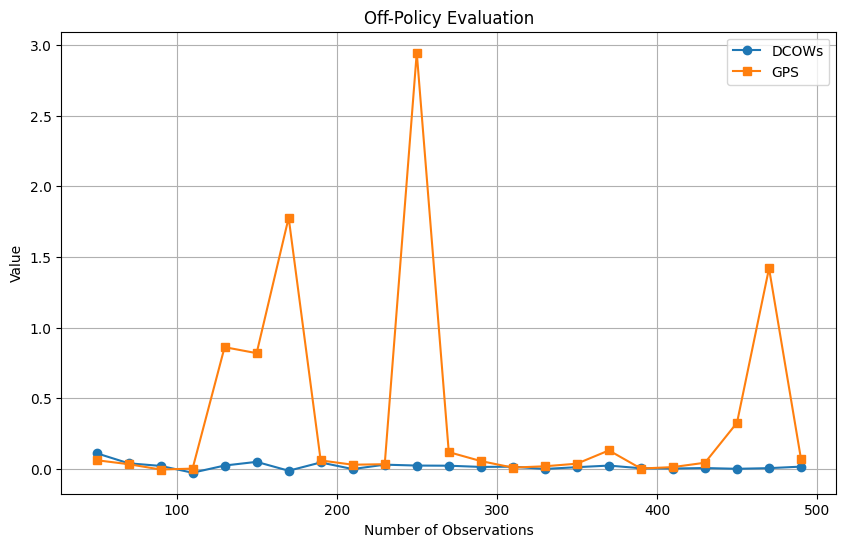

In [8]:

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='osqp.utils')
import matplotlib.pyplot as plt
h = 0.05
n = 1000
t_lo = 2
t_hi = 4

nobs_values = np.arange(50, 501, 20)
value_DCOWs_list = []
value_GPS_list = []
value_true_list = []

for nobs in nobs_values:
    
    data = simulate_data_for_policy_evaulation_2018(seed=1, nobs=nobs, MX1=-0.5, MX2=1, MX3=0.3, A_effect=True)
    

    
    Y=simulate_data_for_policy_evaulation_2018(seed=1, nobs=nobs, MX1=-0.5, MX2=1, MX3=0.3, A_effect=True)['data']['Y']
    
    A=simulate_data_for_policy_evaulation_2018(seed=1, nobs=nobs, MX1=-0.5, MX2=1, MX3=0.3, A_effect=True)['data']['A']
    
    X=simulate_data_for_policy_evaulation_2018(seed=1, nobs=nobs, MX1=-0.5, MX2=1, MX3=0.3, A_effect=True)['data'][['X1','X2','X3','X4','X5']].values
    
    tau = np.sum(X, axis=1)
    
    
    
    value_DCOWs = off_policy_evaulation_DCOWs(y=Y, x=X, tau=tau, T=A, h=h,  n=nobs, t_lo=t_lo, t_hi=t_hi, kernel_func=gaussian_kernel, kernel_int_func=epanechnikov_int)
    
    value_GPS = off_policy_evaulation_GPS(y=Y, x=X, tau=tau, T=A, h=h, Q=GPS_Q, n=nobs, t_lo=t_lo, t_hi=t_hi, kernel_func=gaussian_kernel, kernel_int_func=epanechnikov_int,threshold=1e-2)
    
    #value_true = np.mean(Y)
    
    
    

    
    
    #print(value_true)
    value_DCOWs_list.append(value_DCOWs)
    value_GPS_list.append(np.mean(value_GPS))
    #value_true_list.append(value_true)
    
    
    
plt.figure(figsize=(10, 6))
plt.plot(nobs_values, value_DCOWs_list, marker='o', label='DCOWs')
plt.plot(nobs_values, value_GPS_list, marker='s', label='GPS')
#plt.plot(nobs_values, value_true_list, marker='x', label='True')
#plt.yscale('log')
plt.xlabel('Number of Observations')
plt.ylabel('Value')
plt.title('Off-Policy Evaluation')
plt.legend()
plt.grid(True)
plt.show()

w_i: 23.206122940285255, y_out[i]: 2.549062904448156, n: 300, h: 0.05, alpha: 1, kernel((clip_tau[i] - T[i]) / h):0.3926343240453176 Q_i: 0.01, f_t[i]: 0.23206122940285256 delta_mu: 1.548389242694338
w_i: 15.92703587243188, y_out[i]: 2.555728120509169, n: 300, h: 0.05, alpha: 0.5, kernel((clip_tau[i] - T[i]) / h):0.3929200151184413 Q_i: 0.01, f_t[i]: 0.1592703587243188 delta_mu: 1.0662584913031055


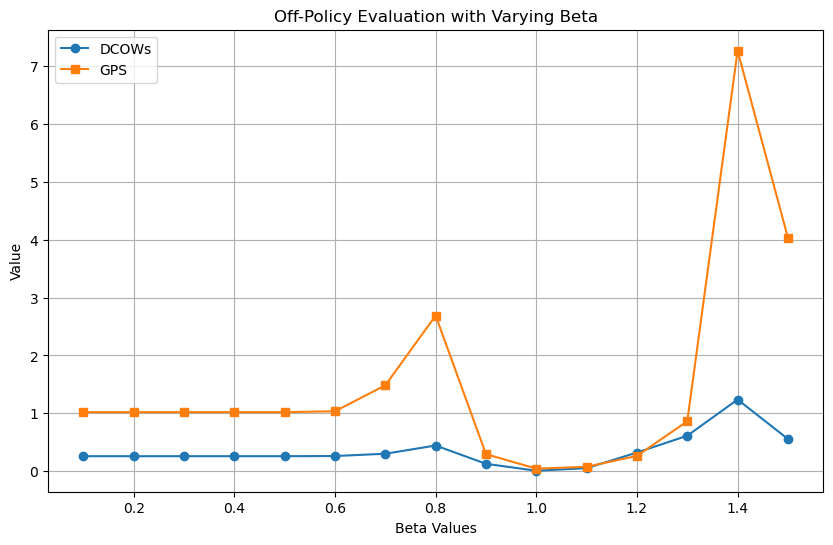

In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='osqp.utils')
import matplotlib.pyplot as plt
import numpy as np

h = 0.05
n = 300
t_lo = 2
t_hi = 4

beta_values = np.arange(0.1, 1.6, 0.1)
value_DCOWs_list = []
value_GPS_list = []

for beta in beta_values:
    data = simulate_data_for_policy_evaulation_2018(seed=1, nobs=n, MX1=-0.5, MX2=1, MX3=0.3, A_effect=True)
    
    Y = data['data']['Y']
    A = data['data']['A']
    X = data['data'][['X1', 'X2', 'X3', 'X4', 'X5']].values
    
    tau = beta * np.sum(X, axis=1)
    
    value_DCOWs = off_policy_evaulation_DCOWs(y=Y, x=X, tau=tau, T=A, h=h, n=n, t_lo=t_lo, t_hi=t_hi, kernel_func=gaussian_kernel, kernel_int_func=epanechnikov_int)
    
    value_GPS = off_policy_evaulation_GPS(y=Y, x=X, tau=tau, T=A, h=h, Q=GPS_Q, n=n, t_lo=t_lo, t_hi=t_hi, kernel_func=gaussian_kernel, kernel_int_func=epanechnikov_int, threshold=1e-2)
    
    value_DCOWs_list.append(value_DCOWs)
    value_GPS_list.append(np.mean(value_GPS))

plt.figure(figsize=(10, 6))
plt.plot(beta_values, value_DCOWs_list, marker='o', label='DCOWs')
plt.plot(beta_values, value_GPS_list, marker='s', label='GPS')
plt.xlabel('Beta Values')
plt.ylabel('Value')
plt.title('Off-Policy Evaluation with Varying Beta')
plt.legend()
plt.grid(True)
plt.show()


This result shows where the DCOWs shines because the generalized propensity score can be easy to get very large when the estimation of $f(t_i|x_i)$ is small and can make large bias in some n while the method DCOWs doesn't have this problem and it is free of assumption.

# Additional simulation for policy evaluation
In order to show the effect in a more general setting, we designed an additional simulation study in the space of linear policy，all the setting of X and T is the same as the previous setting in Vegetabile et al. (2021), except the definition of Y, because we want the true value function to be zero.
  
$\mu_{X1} = -0.5$, $\mu_{X2} = 1$, $\mu_{X3} = 0.3$
 
$X1 \sim \mathcal{N}(\mu_{X1}, 1)$, $X2 \sim \mathcal{N}(\mu_{X2}, 1)$, $X3 \sim \mathcal{N}(0, 1)$, $X4 \sim \mathcal{N}(\mu_{X2}, 1)$, $X5 \sim \text{Bernoulli}(\mu_{X3})$

$\mu_A = 5 |X1| + 6 |X2| + 3 |X5| + |X4|$  
$A \sim \mathcal{N}(0, 1)+\mu_A$

$Y=(2x_1+2x_2+2x_3+2x_4+2x_5-t)^{2}+5(2x_1+2x_2+2x_3+2x_4+2x_5-t)+\epsilon$

We can see that the best policy gets when vector $\beta=2$

In [14]:
from sklearn.linear_model import LinearRegression
from scipy.stats import truncnorm
from scipy.stats import norm
def trunc_norm_Q(x, t, t_lo, t_hi):
    # Get pdf from  truncated normally distributed propensity score (standard normal centered around (x-t)
    # I was wondering if this is the GPS method
    sc = 0.5
    mu = np.mean(x)
    a, b = (t_lo - mu) / sc, (t_hi - mu) / sc
    return truncnorm.pdf(t, a,b, loc = mu, scale = sc)

def GPS_Q(x, t, mu, coef, sigma):
    
    mean = mu + np.dot(x, coef)
    
    pdf_value = norm.pdf(t, loc=mean, scale=sigma)
    return pdf_value
    

def epanechnikov_kernel(u):
    return 0.75*(1-u**2)*(1 if abs(u) <= 1 else 0)

def simulate_data_for_policy_evaulation(seed=99, nobs=1000, MX1=-0.5, MX2=1, MX3=0.3, A_effect=True):
    np.random.seed(seed)

    # Generate covariates and dose
    X1 = np.random.normal(loc=MX1, scale=1, size=nobs)
    X2 = np.random.normal(loc=MX2, scale=1, size=nobs)
    X3 = np.random.normal(loc=0, scale=1, size=nobs)
    X4 = np.random.normal(loc=MX2, scale=1, size=nobs)
    X5 = np.random.binomial(n=1, p=MX3, size=nobs)
    #X1 = np.random.uniform(low=0, high=1, size=nobs)
    #X2 = np.random.uniform(low=0, high=1, size=nobs)
    #X3 = np.random.uniform(low=0, high=1, size=nobs)
    #X4 = np.random.uniform(low=0, high=1, size=nobs)
    #X5 = np.random.uniform(low=0, high=1, size=nobs)


    muA = 5 * np.abs(X1) + 6 * np.abs(X2) + 3 * np.abs(X5) + np.abs(X4)

    A = 2*np.random.normal(scale=1, size=nobs) + muA
    #A=2*(X1+X2+X3+X4+X5)+0.1+0.8*np.random.normal(scale=1, size=nobs)

    

    if A_effect:
        Y = -(2*(X1+X2+X3+X4+X5)-A)**2+5*(2*(X1+X2+X3+X4+X5)-A) + 20*np.random.normal(scale=1, size=nobs)
        #Y = 2*pow(np.abs(2*(X1+X2+X3+X4+X5)-A),1.5)+0.2* np.random.normal(scale=1, size=nobs)
        
        
        truth = A**2-1.22*A+2.994
        
    else:
        
        Y = X1 + X1 ** 2 + X2 + X2 ** 2 + X1 * X2 + \
            X5 + np.random.normal(scale=1, size=nobs)
        truth = 5.05
    

    data = pd.DataFrame({
        'Y': Y,
        'A': A,
        'X1': X1,
        'X2': X2,
        'X3': X3,
        'X4': X4,
        'X5': X5,
        'truth': truth
    })

    

    return {
        'data': data,
        'true_adrf': truth,
        
    }



def linear_tau(x, beta): 
    return np.dot(beta,x)



def gaussian_kernel(u):
    return np.exp(-0.5 * u**2 )/(np.sqrt(2*np.pi))

def epanechnikov_int(lo,hi):
    '''
    :return: Definite integral of the kernel from between lo and hi. Assumes that they are within bounds.
    '''
    return 0.75*(hi-hi**3/3.0) - 0.75*(lo-lo**3/3.0)







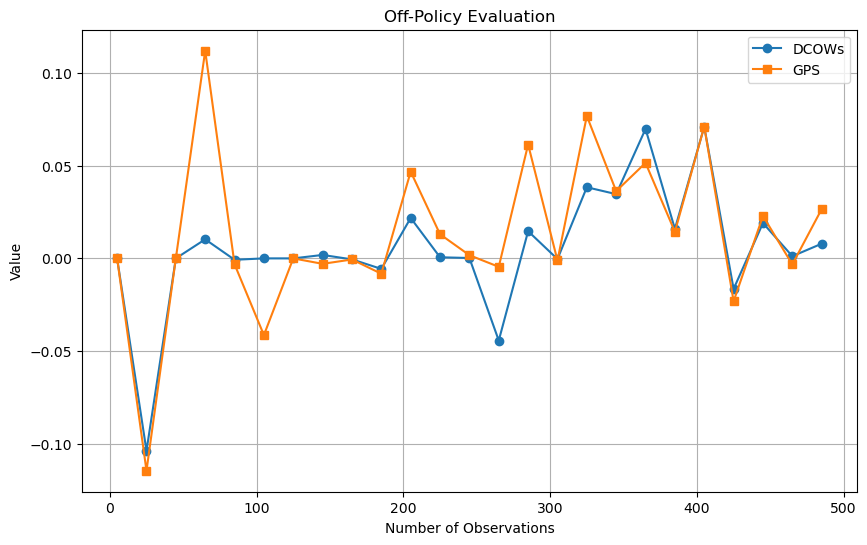

In [9]:

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='osqp.utils')
import matplotlib.pyplot as plt
h = 0.1
n = 1000
t_lo = -8
t_hi = 10

nobs_values = np.arange(5, 501, 20)
value_DCOWs_list = []
value_GPS_list = []
value_true_list = []

for nobs in nobs_values:
    
    data = simulate_data_for_policy_evaulation(seed=1, nobs=nobs, MX1=-0.5, MX2=1, MX3=0.3, A_effect=True)
    

    
    Y=simulate_data_for_policy_evaulation(seed=1, nobs=nobs, MX1=-0.5, MX2=1, MX3=0.3, A_effect=True)['data']['Y']
    
    A=simulate_data_for_policy_evaulation(seed=1, nobs=nobs, MX1=-0.5, MX2=1, MX3=0.3, A_effect=True)['data']['A']
    
    X=simulate_data_for_policy_evaulation(seed=1, nobs=nobs, MX1=-0.5, MX2=1, MX3=0.3, A_effect=True)['data'][['X1','X2','X3','X4','X5']].values
    
    tau = 2*np.sum(X, axis=1)
    
    
    
    value_DCOWs = off_policy_evaulation_DCOWs(y=Y, x=X, tau=tau, T=A, h=h,  n=nobs, t_lo=t_lo, t_hi=t_hi, kernel_func=gaussian_kernel, kernel_int_func=epanechnikov_int)
    
    value_GPS = off_policy_evaulation_GPS(y=Y, x=X, tau=tau, T=A, h=h, Q=GPS_Q, n=nobs, t_lo=t_lo, t_hi=t_hi, kernel_func=gaussian_kernel, kernel_int_func=epanechnikov_int,threshold=1e-2)
    
    #value_true = np.mean(Y)
    
    
    

    
    
    #print(value_true)
    value_DCOWs_list.append(value_DCOWs)
    value_GPS_list.append(np.mean(value_GPS))
    #value_true_list.append(value_true)
    
    
    
plt.figure(figsize=(10, 6))
plt.plot(nobs_values, value_DCOWs_list, marker='o', label='DCOWs')
plt.plot(nobs_values, value_GPS_list, marker='s', label='GPS')
#plt.plot(nobs_values, value_true_list, marker='x', label='True')
#plt.yscale('log')
plt.xlabel('Number of Observations')
plt.ylabel('Value')
plt.title('Off-Policy Evaluation')
plt.legend()
plt.grid(True)
plt.show()


We can see that the result still have the bias from the kernel method and the two method almost have the same bias. Maybe I should find a design of the covariate that make the DCOWs performs better than other methods. And maybe we can find other ways to show our method has better performance.

# Tasks I may want to do next
1. Finish the policy optimization part and show the bias of the value function in the optimal policy
2. Compare the DCOWs with other method like GBM BART Entropy CBPS etc.
3. The better estimation of the value function does not mean we can get a better policy
4. Proof our bound is lower than the existed paper? (I don't know how to do that yet)
5. Possible Extensions   

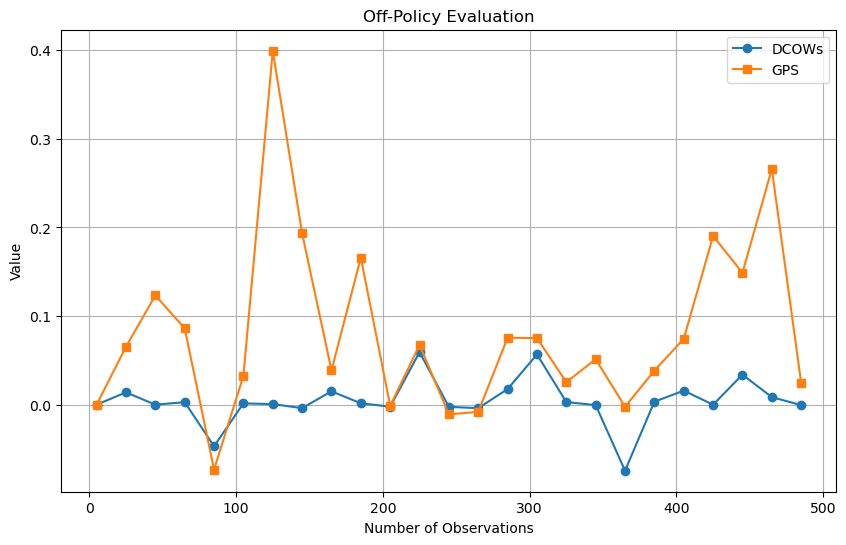

In [15]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='osqp.utils')
import matplotlib.pyplot as plt
h = 0.1
n = 1000
t_lo = -8
t_hi = 10

nobs_values = np.arange(5, 501, 20)
value_DCOWs_list = []
value_GPS_list = []
value_true_list = []

for nobs in nobs_values:
    
    data = simulate_data(seed=1, nobs=nobs, MX1=-0.5, MX2=1, MX3=0.3, A_effect=True)
    

    
    Y=simulate_data(seed=1, nobs=nobs, MX1=-0.5, MX2=1, MX3=0.3, A_effect=True)['data']['Y']
    
    A=simulate_data(seed=1, nobs=nobs, MX1=-0.5, MX2=1, MX3=0.3, A_effect=True)['data']['A']
    
    X=simulate_data(seed=1, nobs=nobs, MX1=-0.5, MX2=1, MX3=0.3, A_effect=True)['data'][['Z1','Z2','Z3','Z4','Z5']].values
    
    tau = 4*np.sum(X, axis=1)
    
    
    
    value_DCOWs = off_policy_evaulation_DCOWs(y=Y, x=X, tau=tau, T=A, h=h,  n=nobs, t_lo=t_lo, t_hi=t_hi, kernel_func=gaussian_kernel, kernel_int_func=epanechnikov_int)
    
    value_GPS = off_policy_evaulation_GPS(y=Y, x=X, tau=tau, T=A, h=h, Q=GPS_Q, n=nobs, t_lo=t_lo, t_hi=t_hi, kernel_func=gaussian_kernel, kernel_int_func=epanechnikov_int,threshold=1e-2)
    
    #value_true = np.mean(Y)
    
    
    

    
    
    #print(value_true)
    value_DCOWs_list.append(value_DCOWs)
    value_GPS_list.append(np.mean(value_GPS))
    #value_true_list.append(value_true)
    
    
    
plt.figure(figsize=(10, 6))
plt.plot(nobs_values, value_DCOWs_list, marker='o', label='DCOWs')
plt.plot(nobs_values, value_GPS_list, marker='s', label='GPS')
#plt.plot(nobs_values, value_true_list, marker='x', label='True')
#plt.yscale('log')
plt.xlabel('Number of Observations')
plt.ylabel('Value')
plt.title('Off-Policy Evaluation')
plt.legend()
plt.grid(True)
plt.show()